In [34]:
import numpy as np
import pandas as pd
import json
import h5py
import sklearn as sk
import matplotlib.pyplot as plt
from obspy import Stream, Trace, UTCDateTime
import seaborn as sns
import os
import sys
import csv
from random import randint
import pprint
import math

base_dir = 'C:\Documents\Thesis_ssd\MasterThesis-2.0'
os.chdir(base_dir)

from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.BaselineHelperFunctions import BaselineHelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.DataProcessing.DataGenerator import DataGenerator
from Classes.Modeling.Models import Models
from Classes.Modeling.RandomGridSearch import RandomGridSearch
from Classes.Modeling.CustomCallback import CustomCallback
from Classes.Scaling.ScalerFitter import ScalerFitter
from Classes.Scaling.MinMaxScalerFitter import MinMaxScalerFitter
from Classes.Scaling.StandardScalerFitter import StandardScalerFitter

# TODO: Consider this: https://stackoverflow.com/questions/47324756/attributeerror-module-matplotlib-has-no-attribute-plot

In [89]:
loadData = LoadData(num_classes = 2, isBalanced = True)
shuffle = False
full_ds, train_ds, val_ds, test_ds = loadData.getDatasets(shuffle = shuffle)
handler = DataHandler()
pp = pprint.PrettyPrinter(indent=4)
helper = BaselineHelperFunctions()

In [28]:
scalerFitter = StandardScalerFitter(train_ds)
scaler = scalerFitter.fit_scaler(test = False, detrend = False)

In [90]:
single_dp_index = 11
one_X, one_y = train_ds[single_dp_index]
one_X, one_info = handler.path_to_trace(one_X)
#one_X_sc= scalerFitter.transform_sample(one_X)

#print(one_X)
print(one_y)
#pp.pprint(one_info)
#print(one_X_sc)

noise


In [91]:
start_time = one_info['origins'][0]['time']

KeyError: 'origins'

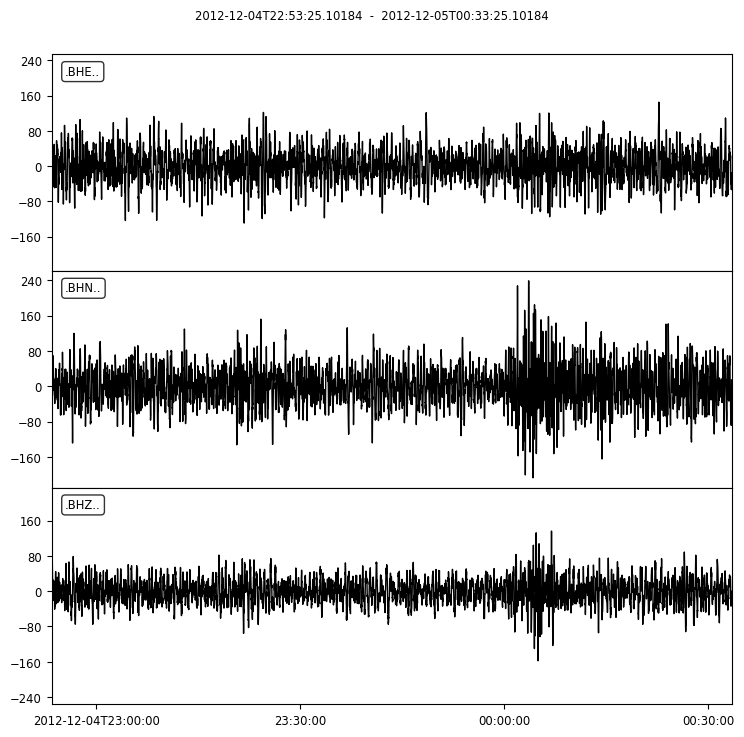

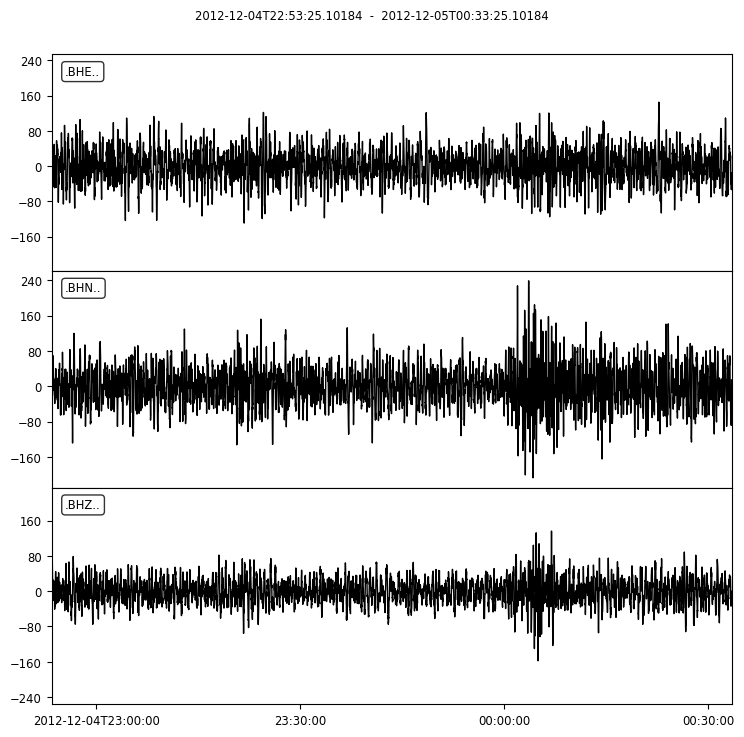

In [92]:
data = new_x
trace_BHE = Trace(
    data=data[0],
    header={
        'starttime': start_time,'station' : "BHZ"})
trace_BHN = Trace(
    data=data[1],
    header={'starttime': start_time,'station' : "BHN"}
)
trace_BHZ = Trace(
    data=data[2],
    header={'starttime': start_time,'station' : "BHE"})

# Assemple into a Stream
stream = Stream([trace_BHE, trace_BHN, trace_BHZ])
stream_copy = stream.copy()
# Plot it
stream.plot()


In [93]:
new_x

array([[ -78.95052831,  -53.09150583,  -20.94263036, ...,  -16.32512381,
         -24.37488235,   -0.48830232],
       [-111.54277974,  -80.96217526,  -51.98078117, ...,  -56.38763274,
          -8.82899973,   14.41053793],
       [  33.31674934,   27.47649591,   -5.11553426, ...,  -53.33282686,
         -40.36189257,  -15.11686492]])

In [94]:
def get_noise(ds):
    noise_ds = []
    for path, label in ds:
        if label == "noise":
            noise_ds.append([path,label])
    return np.array(noise_ds)

def get_mean_noise(noise_ds):
    noise_power_total = 0
    for path, label in noise_ds:
        noise_power_total += np.mean(handler.path_to_trace(path)[0])
    return noise_power_total / len(noise_ds)

def get_noise_std(noise_ds):
    total_std = 0
    for path, label in noise_ds:
        total_std += np.std(handler.path_to_trace(path)[0])
    return total_std / len(noise_ds)

In [95]:
noise_ds = get_noise(full_ds)

In [96]:
avg_power = get_noise_power(noise_ds)

In [97]:
noise_std = get_noise_std(noise_ds)

In [98]:
avg_power, noise_std

(0.00066038755666416541, 60.223036485968983)

In [99]:
def create_noise(mean, std, sample_shape):
    noise = np.random.normal(mean, std, (sample_shape))
    return noise

def noise_to_signal(sample, mean, std):
    noise = create_noise(mean,std, sample.shape)
    return sample + noise
    

In [100]:
new_x = noise_to_signal(one_X, avg_power, noise_std/10)

In [101]:
scaler = StandardScalerFitter(train_ds).fit_scaler(test = False, detrend = False)

In [103]:
data_gen = DataGenerator()
gen_args = {
    'batch_size' : 32,
    'test' : False,
    'detrend' : False,
    'useScaler' : False,
    'scaler' : scaler,
    'num_classes' : 2,
    'use_highpass' : False,
    'highpass_freq' : 0.2
}


train_gen = data_gen.data_generator(train_ds, **gen_args)

In [104]:
X, y = next(train_gen)

In [105]:
def batch_augment_noise(X, mean, std):
    noise = create_noise(mean, std, X.shape)
    X = X + noise
    return X

In [106]:
X_noised = batch_augment_noise(X, 0, noise_std/10)

In [109]:
X_noised

array([[[  7.05957207e+01,   7.88241478e+01,   6.90093384e+01, ...,
          -2.39673030e+01,  -2.96912580e+01,  -3.37655003e+01],
        [  1.48588436e+01,  -2.31801829e+00,   1.78346952e+01, ...,
           1.11691102e+01,  -6.90573108e+00,  -1.19432491e+01],
        [  5.95741705e+01,   6.10660380e+01,   4.62982260e+01, ...,
           6.40857254e+00,   1.96361224e+01,   1.24115582e+01]],

       [[ -7.18916541e+00,   4.31875285e+00,  -2.19328437e-01, ...,
           6.84380722e+00,   4.28862789e+00,   2.54182336e+01],
        [  3.28257999e+01,   2.35150141e+01,   2.14339589e+01, ...,
          -3.39332288e+01,  -3.47326627e+01,  -3.84881570e+01],
        [ -1.63453033e+01,  -2.55500981e+01,  -4.02398367e+01, ...,
           3.21239911e+01,   4.30588114e+01,   1.29769224e+01]],

       [[ -1.69187766e+01,   8.31462184e+00,   2.63151054e+01, ...,
          -4.10155287e+00,   2.59234636e+00,  -2.91033719e+01],
        [ -1.22962679e+01,  -1.61398695e+01,   4.29488516e+00, ...,
    

In [41]:
create_noise(scaler.mean_, std)

array([[ -490.68492037,    18.98353246,  -119.22588644, ...,
          761.56667556,   636.02254133,  -449.19977292],
       [ -214.58082295,  -694.92067426,  -191.77560665, ...,
         -337.43214094,  1085.66082914,   245.02803385],
       [ 1717.95803929,   249.30902117,   -75.39862801, ...,
         -107.47228899,  -691.44442298,   689.66663387]])

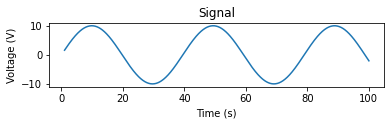

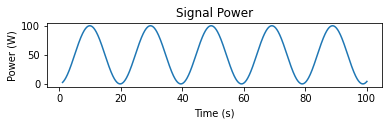

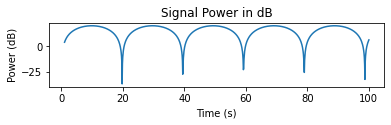

In [47]:
# Signal Generation
# matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

t = np.linspace(1, 100, 1000)
x_volts = 10*np.sin(t/(2*np.pi))
plt.subplot(3,1,1)
plt.plot(t, x_volts)
plt.title('Signal')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()

x_watts = x_volts ** 2
plt.subplot(3,1,2)
plt.plot(t, x_watts)
plt.title('Signal Power')
plt.ylabel('Power (W)')
plt.xlabel('Time (s)')
plt.show()

x_db = 10 * np.log10(x_watts)
plt.subplot(3,1,3)
plt.plot(t, x_db)
plt.title('Signal Power in dB')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)')
plt.show()

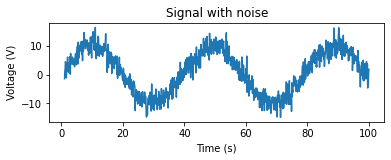

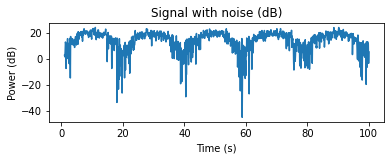

In [51]:
# Adding noise using target SNR

# Set a target SNR
target_snr_db = 10
# Calculate signal power and convert to dB 
sig_avg_watts = np.mean(x_watts)
sig_avg_db = 10 * np.log10(sig_avg_watts)
# Calculate noise according to [2] then convert to watts
noise_avg_db = sig_avg_db - target_snr_db
noise_avg_watts = 10 ** (noise_avg_db / 10)
# Generate an sample of white noise
mean_noise = 0
noise_volts = np.random.normal(mean_noise, np.sqrt(noise_avg_watts), len(x_watts))
# Noise up the original signal
y_volts = x_volts + noise_volts

# Plot signal with noise
plt.subplot(2,1,1)
plt.plot(t, y_volts)
plt.title('Signal with noise')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.show()
# Plot in dB
y_watts = y_volts ** 2
y_db = 10 * np.log10(y_watts)
plt.subplot(2,1,2)
plt.plot(t, 10* np.log10(y_volts**2))
plt.title('Signal with noise (dB)')
plt.ylabel('Power (dB)')
plt.xlabel('Time (s)')
plt.show()

In [5]:
def get_single_semirandom_dp(generator, data_csv, class_type = ""):
    len_ds = len(data_csv)
    random_int = randint(0,len_ds-1)
    if class_type == "": 
        single_trace = generator.path_to_trace(data_csv[random_int][0])[0]
    else:
        single_trace = generator.path_to_trace(data_csv[random_int][0])[0]
        single_event_type = data_csv[random_int][1]
        while(single_event_type != class_type):
            random_int = randint(0,len_ds-1)
            single_trace = generator.path_to_trace(data_csv[random_int][0])[0]
            single_event_type = data_csv[random_int][1]
    single_event_info = generator.path_to_trace(data_csv[random_int][0])[1]
    return single_trace, single_event_info
    